## An Analysis of Player Retention and Churn in a First-Person Shooter Game
Player data for this project has been generated through a Python script.

### Goals
1. Calculate the churn rate across different regions
2. Identify patterns in retention

## Data Type Issues and Missing Data
After an initial look at the data with the info() function we can see that there is some missing data in the Region field.

**region 6647 count compared to all other fields showing 10075**

This missing data is currently in the form of NaN so should be fine for further analysis, but we can change later if it doesn't align with our project goals.

The *session_start* and *session_end* fields are also a combined timestamp which may be more useful as separated time and date.

In [ ]:
# Import requried libraries
import pandas as pd
from datetime import datetime

# Read game session data from csv
df = pd.read_csv('../Data/game_sessions.csv')

# Initial look at potential missing data and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   player_id          10075 non-null  object
 1   session_id         10075 non-null  object
 2   session_start      10075 non-null  object
 3   session_end        10075 non-null  object
 4   platform           10075 non-null  object
 5   region             6647 non-null   object
 6   kills              10075 non-null  int64 
 7   deaths             10075 non-null  int64 
 8   level              10075 non-null  int64 
 9   is_premium_user    10075 non-null  bool  
 10  made_purchase      10075 non-null  bool  
 11  days_since_signup  10075 non-null  int64 
 12  churned            10075 non-null  bool  
dtypes: bool(3), int64(4), object(6)
memory usage: 816.8+ KB


### Duplicates
No duplicates were found so the original dataframe will continue to be used.

In [92]:
# Make copy of original dataframe
df_unique = df

# Remove duplicates from the new df
df_unique = df_unique.drop_duplicates()

# Output changes between original and new df
print ('df contains ', len(df), ' records.')
print ('df_unique contains ', len(df_unique), ' records.')
print ('Rows dropped: ', len(df)-len(df_unique))

df contains  10075  records.
df_unique contains  10075  records.
Rows dropped:  0


## Session Date and Time
Convert session_start/end to a datetime object.

In [93]:
# Convert session_start and session_end to datetime object
df['session_start'] = pd.to_datetime(df.session_start)
df['session_end'] = pd.to_datetime(df.session_end)

## Brief Analysis of the Session Duration

In [94]:
# Adding session duration field
df['session_duration'] = (df.session_end - df.session_start) / pd.Timedelta(minutes=1)
median_duration = df.session_duration.mean()

df.session_duration.describe()

count    10075.000000
mean        92.642978
std         50.254860
min          5.000000
25%         49.000000
50%         93.000000
75%        136.000000
max        179.000000
Name: session_duration, dtype: float64

## Average session length by region

<Axes: title={'center': 'Session Duration by Region'}, xlabel='region'>

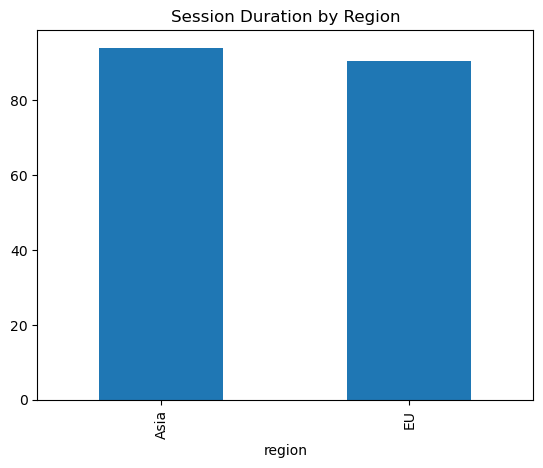

In [95]:
# Group by region and get mean session duration
duration_by_region = df.groupby('region')['session_duration'].mean()
duration_by_region.plot(kind='bar', title='Session Duration by Region')

## Average session length by platform

<Axes: title={'center': 'Session Duration by Platform'}, xlabel='platform'>

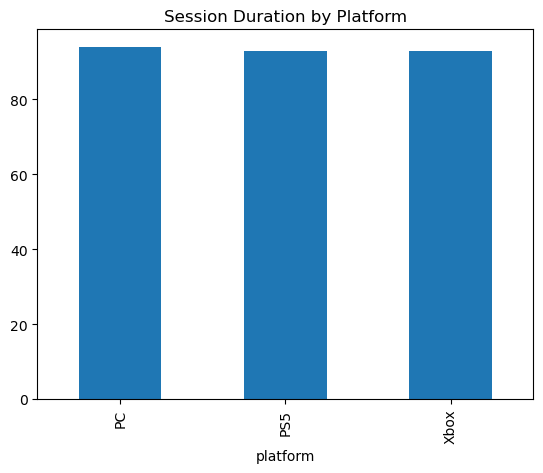

In [96]:
# Group by platform and get median session duration
duration_by_platform = df.groupby('platform')['session_duration'].median()
duration_by_platform.plot(kind='bar', title='Session Duration by Platform')

## Player Percentage Retention over 7, 14 and 30 days

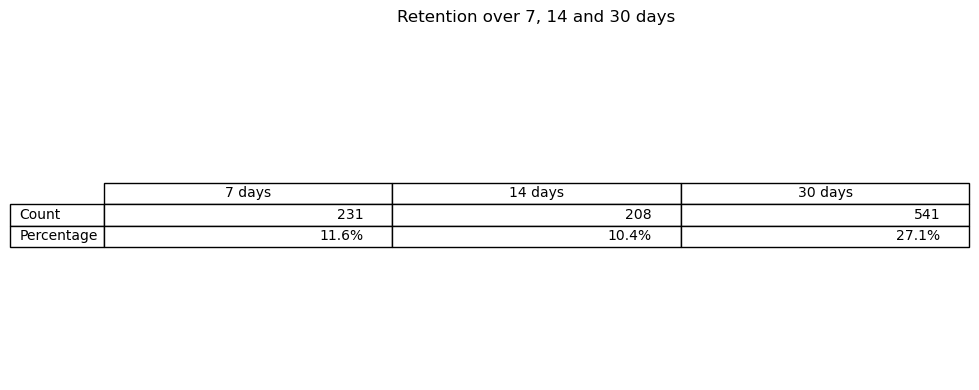

Player retention in 7 days is 11.6%, over 14 days is 10.4% and over 30 days is 27.1%


In [161]:
import matplotlib.pyplot as plt

churn_7days = df.groupby('player_id')['days_since_signup'].max().between(1, 7).sum()
churn_14days = df.groupby('player_id')['days_since_signup'].max().between(8, 14).sum()
churn_30days = df.groupby('player_id')['days_since_signup'].max().between(15, 30).sum()

total_players = df.player_id.nunique()

retention_7days = ( churn_7days / total_players ) * 100
retention_14days = ( churn_14days / total_players ) * 100
retention_30days = ( churn_30days / total_players ) * 100

retention = [{'7 days': churn_7days, '14 days': churn_14days, '30 days': churn_30days}, 
             {'7 days': f"{retention_7days:.1f}%", '14 days': f"{retention_14days:.1f}%", '30 days': f"{retention_30days:.1f}%"}]

retention_labels = ['Count', 'Percentage']

fix, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')
retention_data = pd.DataFrame(retention)
retention_table = ax.table(cellText=retention_data.values,
                 colLabels=retention_data.columns,
                 rowLabels=retention_labels,
                 loc='center')

retention_table.auto_set_font_size(False)
retention_table.set_fontsize(10)
retention_table.scale(1.2, 1.2)

plt.title("Retention over 7, 14 and 30 days", pad=20)
plt.tight_layout()
plt.show()

print (f'Player retention in 7 days is {retention_7days:.1f}%, over 14 days is {retention_14days:.1f}% and over 30 days is {retention_30days:.1f}%')

## Player churn within 7, 14 and 30 days by Platform


In [136]:
platforms = df.groupby('player_id')['platform'].first().reset_index()
platforms.columns = ['player_id', 'platform']

last_play = df.groupby('player_id')['days_since_signup'].max().reset_index()
last_play.columns = ['player_id', 'days_since_signup']

last_played = pd.merge(last_play, platforms, on='player_id')

thresholds = [7, 14, 30]
platform_churn = {}

for platform in ['PC', 'PS5', 'Xbox']:
    subset = last_played[last_played['platform'] == platform]
    platform_churn[platform] = {}

    for t in thresholds:
        churned = subset[subset['days_since_signup'] <= t]
        platform_churn[platform][f'{t} days'] = len(churned)
        platform_churn[platform][f'{t} days %'] = (
            f'{len(churned) / len(subset):.1%}' if len(subset) > 0 else "N/A"
        )

platform_churn

{'PC': {'7 days': 78,
  '7 days %': '11.2%',
  '14 days': 140,
  '14 days %': '20.1%',
  '30 days': 320,
  '30 days %': '45.9%'},
 'PS5': {'7 days': 74,
  '7 days %': '11.5%',
  '14 days': 139,
  '14 days %': '21.7%',
  '30 days': 323,
  '30 days %': '50.3%'},
 'Xbox': {'7 days': 79,
  '7 days %': '12.0%',
  '14 days': 160,
  '14 days %': '24.2%',
  '30 days': 337,
  '30 days %': '51.0%'}}

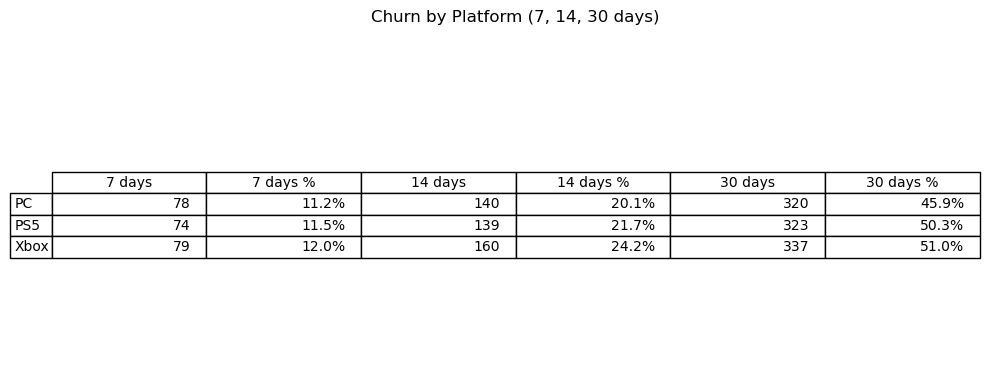

In [ ]:
fix, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')
churn_data = pd.DataFrame(platform_churn).T
churn_table = ax.table(cellText=churn_data.values,
                 colLabels=churn_data.columns,
                 rowLabels=churn_data.index,
                 loc='center')

churn_table.auto_set_font_size(False)
churn_table.set_fontsize(10)
churn_table.scale(1.2, 1.2)

plt.title("Churn by Platform (7, 14, 30 days)", pad=20)
plt.tight_layout()
plt.show()
